# *(Susin & Destexhe, 2021)*: CHING Network for Generating Gamma Oscillation

Implementation of the paper:

- Susin, Eduarda, and Alain Destexhe. "Integration, coincidence detection and
  resonance in networks of spiking neurons expressing gamma oscillations and
  asynchronous states." PLoS computational biology 17.9 (2021): e1009416.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import kaiserord, lfilter, firwin, hilbert

import brainpy as bp
import brainpy.math as bm

In [2]:
# Table 1: specific neuron model parameters
RS_par = dict(Vth=-40, delta=2., tau_ref=5., tau_w=500, a=4, b=20, C=150, gL=10, EL=-65, V_reset=-65,
              E_e=0., E_i=-80.)
FS_par = dict(Vth=-47.5, delta=0.5, tau_ref=5., tau_w=500, a=0, b=0, C=150, gL=10, EL=-65, V_reset=-65,
              E_e=0., E_i=-80.)
Ch_par = dict(Vth=-47.5, delta=0.5, tau_ref=1., tau_w=50, a=80, b=150, C=150, gL=10, EL=-58, V_reset=-65,
              E_e=0., E_i=-80.)

In [3]:
class AdEx(bp.NeuGroup):
  def __init__(
      self,
      size,

      # neuronal parameters
      Vth=-40, delta=2., tau_ref=5., tau_w=500, a=4, b=20, C=150,
      gL=10, EL=-65, V_reset=-65, V_sp_th=-30.,

      # synaptic parameters
      tau_e=1.5, tau_i=7.5, E_e=0., E_i=-80.,

      # other parameters
      name=None, method='exp_euler',
      V_initializer=bp.init.Uniform(-65, -50),
      w_initializer=bp.init.Constant(0.),
  ):
    super(AdEx, self).__init__(size=size, name=name)

    # neuronal parameters
    self.Vth = Vth
    self.delta = delta
    self.tau_ref = tau_ref
    self.tau_w = tau_w
    self.a = a
    self.b = b
    self.C = C
    self.gL = gL
    self.EL = EL
    self.V_reset = V_reset
    self.V_sp_th = V_sp_th

    # synaptic parameters
    self.tau_e = tau_e
    self.tau_i = tau_i
    self.E_e = E_e
    self.E_i = E_i

    # neuronal variables
    self.V = bp.init.variable_(V_initializer, self.num)
    self.w = bp.init.variable_(w_initializer, self.num)
    self.spike = bm.Variable(self.num, dtype=bool)
    self.refractory = bm.Variable(self.num, dtype=bool)
    self.t_last_spike = bm.Variable(bm.ones(self.num) * -1e8)

    # synaptic parameters
    self.ge = bm.Variable(self.num)
    self.gi = bm.Variable(self.num)

    # integral
    self.integral = bp.odeint(bp.JointEq(self.dV, self.dw, self.dge, self.dgi), method=method)

  def dge(self, ge, t):
    return -ge / self.tau_e

  def dgi(self, gi, t):
    return -gi / self.tau_i

  def dV(self, V, t, w, ge, gi, Iext=None):
    I = ge * (self.E_e - V) + gi * (self.E_i - V)
    if Iext is not None: I += Iext
    dVdt = (self.gL * self.delta * bm.exp((V - self.Vth) / self.delta)
            - w + self.gL * (self.EL - V) + I) / self.C
    return dVdt

  def dw(self, w, t, V):
    dwdt = (self.a * (V - self.EL) - w) / self.tau_w
    return dwdt

  def update(self, tdi, x=None):
    V, w, ge, gi = self.integral(self.V.value, self.w.value, self.ge.value, self.gi.value,
                                 tdi.t, Iext=x, dt=tdi.dt)
    refractory = (tdi.t - self.t_last_spike) <= self.tau_ref
    V = bm.where(refractory, self.V.value, V)
    spike = V >= self.V_sp_th
    self.V.value = bm.where(spike, self.V_reset, V)
    self.w.value = bm.where(spike, w + self.b, w)
    self.ge.value = ge
    self.gi.value = gi
    self.spike.value = spike
    self.refractory.value = bm.logical_or(refractory, spike)
    self.t_last_spike.value = bm.where(spike, tdi.t, self.t_last_spike)

In [4]:
class CHINGNet(bp.Network):
  def __init__(self, ext_varied_rates, method='exp_euler', dt=bm.get_dt()):
    super(CHINGNet, self).__init__()

    self.num_rs = 19000
    self.num_fs = 5000
    self.num_ch = 1000
    self.exc_syn_tau = 5.  # ms
    self.inh_syn_tau = 5.  # ms
    self.exc_syn_weight = 1.  # nS
    self.inh_syn_weight1 = 7.  # nS
    self.inh_syn_weight2 = 5.  # nS
    self.ext_weight1 = 1.  # nS
    self.ext_weight2 = 0.75  # nS
    self.num_delay_step = int(1.5 / dt)
    self.ext_varied_rates = ext_varied_rates

    # neuronal populations
    RS_par_ = RS_par.copy()
    FS_par_ = FS_par.copy()
    Ch_par_ = Ch_par.copy()
    RS_par_.update(Vth=-50, V_sp_th=-40)
    FS_par_.update(Vth=-50, V_sp_th=-40)
    Ch_par_.update(Vth=-50, V_sp_th=-40)
    self.rs_pop = AdEx(self.num_rs, tau_e=self.exc_syn_tau, tau_i=self.inh_syn_tau, method=method, **RS_par_)
    self.fs_pop = AdEx(self.num_fs, tau_e=self.exc_syn_tau, tau_i=self.inh_syn_tau, method=method, **FS_par_)
    self.ch_pop = AdEx(self.num_ch, tau_e=self.exc_syn_tau, tau_i=self.inh_syn_tau, method=method, **Ch_par_)
    self.ext_pop = bp.neurons.PoissonGroup(self.num_rs, freqs=bm.Variable(1))

    # Poisson inputs
    self.ext_to_FS = bp.synapses.Delta(self.ext_pop, self.fs_pop, bp.conn.FixedProb(0.02),
                                       output=bp.synouts.CUBA(target_var='ge'),
                                       g_max=self.ext_weight2)
    self.ext_to_RS = bp.synapses.Delta(self.ext_pop, self.rs_pop, bp.conn.FixedProb(0.02),
                                       output=bp.synouts.CUBA(target_var='ge'),
                                       g_max=self.ext_weight1)
    self.ext_to_CH = bp.synapses.Delta(self.ext_pop, self.ch_pop, bp.conn.FixedProb(0.02),
                                       output=bp.synouts.CUBA(target_var='ge'),
                                       g_max=self.ext_weight1)

    # synaptic projections
    self.RS_to_FS = bp.synapses.Delta(self.rs_pop, self.fs_pop, bp.conn.FixedProb(0.02),
                                      output=bp.synouts.CUBA(target_var='ge'),
                                      g_max=self.exc_syn_weight,
                                      delay_step=self.num_delay_step)
    self.RS_to_RS = bp.synapses.Delta(self.rs_pop, self.rs_pop, bp.conn.FixedProb(0.02),
                                      output=bp.synouts.CUBA(target_var='ge'),
                                      g_max=self.exc_syn_weight,
                                      delay_step=self.num_delay_step)
    self.RS_to_Ch = bp.synapses.Delta(self.rs_pop, self.ch_pop, bp.conn.FixedProb(0.02),
                                      output=bp.synouts.CUBA(target_var='ge'),
                                      g_max=self.exc_syn_weight,
                                      delay_step=self.num_delay_step)

    self.FS_to_RS = bp.synapses.Delta(self.fs_pop, self.rs_pop, bp.conn.FixedProb(0.02),
                                      output=bp.synouts.CUBA(target_var='gi'),
                                      g_max=self.inh_syn_weight1,
                                      delay_step=self.num_delay_step)
    self.FS_to_FS = bp.synapses.Delta(self.fs_pop, self.fs_pop, bp.conn.FixedProb(0.02),
                                      output=bp.synouts.CUBA(target_var='gi'),
                                      g_max=self.inh_syn_weight2,
                                      delay_step=self.num_delay_step)
    self.FS_to_Ch = bp.synapses.Delta(self.fs_pop, self.ch_pop, bp.conn.FixedProb(0.02),
                                      output=bp.synouts.CUBA(target_var='gi'),
                                      g_max=self.inh_syn_weight1,
                                      delay_step=self.num_delay_step)

    self.Ch_to_RS = bp.synapses.Delta(self.ch_pop, self.rs_pop, bp.conn.FixedProb(0.02),
                                      output=bp.synouts.CUBA(target_var='ge'),
                                      g_max=self.exc_syn_weight,
                                      delay_step=self.num_delay_step)
    self.Ch_to_FS = bp.synapses.Delta(self.ch_pop, self.fs_pop, bp.conn.FixedProb(0.02),
                                      output=bp.synouts.CUBA(target_var='ge'),
                                      g_max=self.exc_syn_weight,
                                      delay_step=self.num_delay_step)
    self.Ch_to_Ch = bp.synapses.Delta(self.ch_pop, self.ch_pop, bp.conn.FixedProb(0.02),
                                      output=bp.synouts.CUBA(target_var='ge'),
                                      g_max=self.exc_syn_weight,
                                      delay_step=self.num_delay_step)

  def change_freq(self, tdi):
    self.ext_pop.freqs[0] = self.ext_varied_rates[tdi.i]


In [5]:
def get_inputs(c_low, c_high, t_transition, t_min_plato, t_max_plato, t_gap, t_total, dt=None):
  dt = bm.get_dt() if dt is None else dt
  t = 0
  num_gap = int(t_gap / dt)
  num_total = int(t_total / dt)
  num_transition = int(t_transition / dt)

  inputs = []
  ramp_up = np.linspace(c_low, c_high, num_transition)
  ramp_down = np.linspace(c_high, c_low, num_transition)
  plato_base = np.ones(num_gap) * c_low
  while t < num_total:
    num_plato = int(np.random.uniform(low=t_min_plato, high=t_max_plato, size=1) / dt)
    inputs.extend([plato_base, ramp_up, np.ones(num_plato) * c_high, ramp_down])
    t += (num_gap + num_transition + num_plato + num_transition)
  return bm.asarray(np.concatenate(inputs)[:num_total])


In [6]:
def signal_phase_by_Hilbert(signal, signal_time, low_cut, high_cut, sampling_space):
  # sampling_space: in seconds (no units)
  # signal_time: in seconds (no units)
  # low_cut: in Hz (no units)(band to filter)
  # high_cut: in Hz (no units)(band to filter)

  signal = signal - np.mean(signal)
  width = 5.0  # The desired width in Hz of the transition from pass to stop
  ripple_db = 60.0  # The desired attenuation in the stop band, in dB.
  sampling_rate = 1. / sampling_space
  Nyquist = sampling_rate / 2.

  num_taps, beta = kaiserord(ripple_db, width / Nyquist)
  if num_taps % 2 == 0:
    num_taps = num_taps + 1  # Numtaps must be odd
  taps = firwin(num_taps, [low_cut / Nyquist, high_cut / Nyquist], window=('kaiser', beta), nyq=1.0,
                pass_zero=False, scale=True)
  filtered_signal = lfilter(taps, 1.0, signal)
  delay = 0.5 * (num_taps - 1) / sampling_rate  # To corrected to zero-phase
  delay_index = int(np.floor(delay * sampling_rate))
  filtered_signal = filtered_signal[num_taps - 1:]  # taking out the "corrupted" signal
  # correcting the delay and taking out the "corrupted" signal part
  filtered_time = signal_time[num_taps - 1:] - delay
  cutted_signal = signal[(num_taps - 1 - delay_index): (len(signal) - (num_taps - 1 - delay_index))]

  # --------------------------------------------------------------------------
  # The hilbert transform are very slow when the signal has odd lenght,
  # This part check if the length is odd, and if this is the case it adds a zero in the end
  # of all the vectors related to the filtered Signal:
  if len(filtered_signal) % 2 != 0:  # If the lengh is odd
    tmp1 = filtered_signal.tolist()
    tmp1.append(0)
    tmp2 = filtered_time.tolist()
    tmp2.append((len(filtered_time) + 1) * sampling_space + filtered_time[0])
    tmp3 = cutted_signal.tolist()
    tmp3.append(0)
    filtered_signal = np.asarray(tmp1)
    filtered_time = np.asarray(tmp2)
    cutted_signal = np.asarray(tmp3)
  # --------------------------------------------------------------------------

  ht_filtered_signal = hilbert(filtered_signal)
  envelope = np.abs(ht_filtered_signal)
  phase = np.angle(ht_filtered_signal)  # The phase is between -pi and pi in radians

  return filtered_time, filtered_signal, cutted_signal, envelope, phase


In [7]:
def visualize_simulation_results(times, spikes, example_potentials, varied_rates,
                                 xlim=None, t_lfp_start=None, t_lfp_end=None, filename=None):
  fig, gs = bp.visualize.get_figure(7, 1, 1, 12)
  # 1. input firing rate
  ax = fig.add_subplot(gs[0])
  plt.plot(times, varied_rates)
  if xlim is None:
    xlim = (0, times[-1])
  ax.set_xlim(*xlim)
  ax.set_xticks([])
  ax.set_ylabel('External\nRate (Hz)')

  # 2. inhibitory cell rater plot
  ax = fig.add_subplot(gs[1: 3])
  i = 0
  y_ticks = ([], [])
  for key, (sp_matrix, sp_type) in spikes.items():
    iis, sps = np.where(sp_matrix)
    tts = times[iis]
    plt.plot(tts, sps + i, '.', markersize=1, label=key)
    y_ticks[0].append(i + sp_matrix.shape[1] / 2)
    y_ticks[1].append(key)
    i += sp_matrix.shape[1]
  ax.set_xlim(*xlim)
  ax.set_xlabel('')
  ax.set_ylabel('Neuron Index')
  ax.set_xticks([])
  ax.set_yticks(*y_ticks)
  # ax.legend()

  # 3. example membrane potential
  ax = fig.add_subplot(gs[3: 5])
  for key, potential in example_potentials.items():
    vs = np.where(spikes[key][0][:, 0], 0, potential)
    plt.plot(times, vs, label=key)
  ax.set_xlim(*xlim)
  ax.set_xticks([])
  ax.set_ylabel('V (mV)')
  ax.legend()

  # 4. LFP
  ax = fig.add_subplot(gs[5:7])
  ax.set_xlim(*xlim)
  t1 = int(t_lfp_start / bm.get_dt()) if t_lfp_start is not None else 0
  t2 = int(t_lfp_end / bm.get_dt()) if t_lfp_end is not None else len(times)
  times = times[t1: t2]
  lfp = 0
  for sp_matrix, sp_type in spikes.values():
    lfp += bp.measure.unitary_LFP(times, sp_matrix[t1: t2], sp_type)
  phase_ts, filtered, cutted, envelope, _ = signal_phase_by_Hilbert(bm.as_numpy(lfp), times * 1e-3, 30, 50,
                                                                    bm.get_dt() * 1e-3)
  plt.plot(phase_ts * 1e3, cutted, color='k', label='Raw LFP')
  plt.plot(phase_ts * 1e3, filtered, color='orange', label="Filtered LFP (30-50 Hz)")
  plt.plot(phase_ts * 1e3, envelope, color='purple', label="Hilbert Envelope")
  plt.legend(loc='best')
  plt.xlabel('Time (ms)')

  # save or show
  if filename:
    plt.savefig(filename, dpi=500)
  plt.show()


In [8]:
def simulate_ching_net():
  duration = 6e3
  varied_rates = get_inputs(1., 2., 50., 150, 600, 1e3, duration)

  net = CHINGNet(varied_rates)
  runner = bp.DSRunner(
    net,
    fun_inputs=net.change_freq,
    fun_monitors={'FS.V0': lambda tdi: net.fs_pop.V[0],
                  'CH.V0': lambda tdi: net.ch_pop.V[0],
                  'RS.V0': lambda tdi: net.rs_pop.V[0],
                  'FS.spike': lambda tdi: net.fs_pop.spike,
                  'CH.spike': lambda tdi: net.ch_pop.spike,
                  'RS.spike': lambda tdi: net.rs_pop.spike}
  )
  runner.run(duration)

  visualize_simulation_results(times=runner.mon.ts,
                               spikes={'FS': (runner.mon['FS.spike'], 'inh'),
                                       'CH': (runner.mon['CH.spike'], 'exc'),
                                       'RS': (runner.mon['RS.spike'], 'exc')},
                               example_potentials={'FS': runner.mon['FS.V0'],
                                                   'CH': runner.mon['CH.V0'],
                                                   'RS': runner.mon['RS.V0']},
                               varied_rates=varied_rates.to_numpy(),
                               xlim=(2e3, 3.4e3), t_lfp_start=1e3, t_lfp_end=5e3)

  0%|          | 0/60000 [00:00<?, ?it/s]

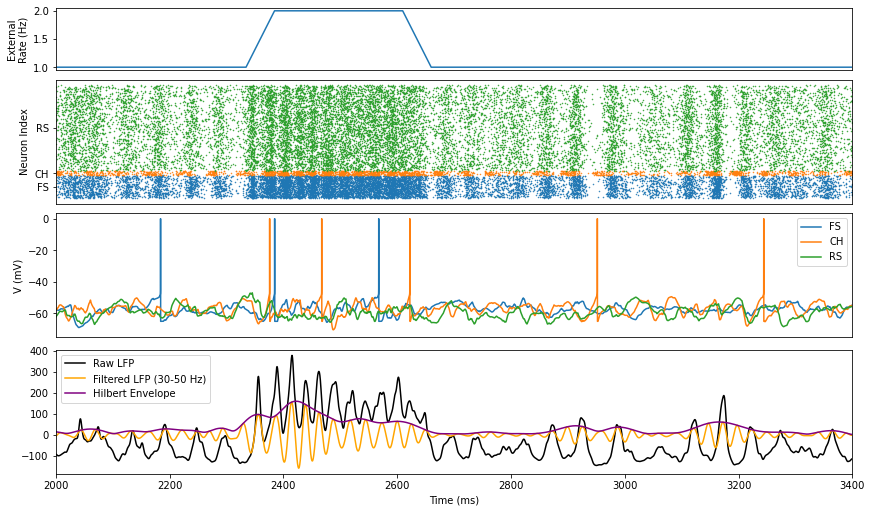

In [9]:
simulate_ching_net()